In this [experiment](G_Image_segmentation_Unet.ipynb), I built U-Net, a type of convolutional neural network that is designed for image segmentation task, with the starting code, instructions, training data and utility functions from the [Convolutional Neural Networks](https://coursera.org/learn/convolutional-neural-networks) course (by DeepLearning.AI on Coursera). Image segmentation aims to classify every pixel of the image as belonging to which object.

Unet architecture (showing the layer dimensions and filter sizes as per the original paper on U-Net. However, in the Coursera assignment, only half of the filters are implemented due to computational constraints.)
![unet.png](images%2Funet.png)


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
%cd /content/drive/Othercomputers/My Laptop/T_Repo/C4_W3_Assignment2/Files/tf/W3A2
%ls

/content/drive/Othercomputers/My Laptop/T_Repo/C4_W3_Assignment2/Files/tf/W3A2
data/                             outputs.py         test_utils.py
G_Image_segmentation_Unet.ipynb   __pycache__/       T_images/
images/                           PythonScript/      T_Image_segmentation_Unet_v2.ipynb
Image_segmentation_Unet_v2.ipynb  readme.md
notebook2script.py                sample_output.png


In [5]:
%load_ext autoreload
%autoreload 2

In [6]:
import tensorflow as tf
import numpy as np
import keras.api._v2.keras as keras
from keras.layers import Input, Conv2D, MaxPool2D, Dropout, Conv2DTranspose, concatenate
from test_utils import summary, comparator

# Loading data

In [7]:
import os
import numpy as np
import pandas as pd
import imageio
import matplotlib.pyplot as plt
%matplotlib inline
path = ''
image_path = os.path.join(path, './data/CameraRGB/')
mask_path = os.path.join(path, './data/CameraMask/')
image_list_orig = os.listdir(image_path)
image_list = [image_path + i for i in image_list_orig]
mask_list = [mask_path + i for i in image_list_orig]

## Viewing a sample image

Text(0.5, 1.0, 'Segmentation')

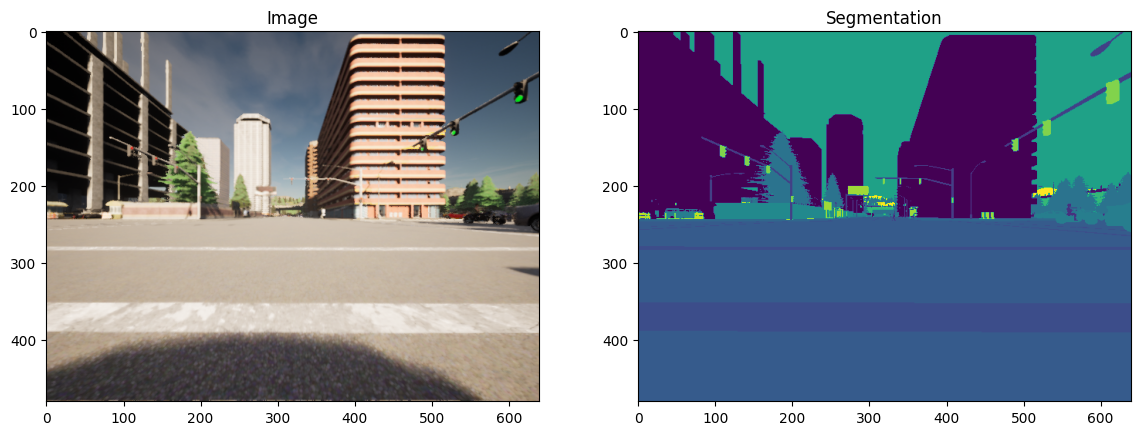

In [8]:
N = 55
img = imageio.v2.imread(image_list[N])
mask = imageio.v2.imread(mask_list[N])
# mask = np.array([max(mask[i, j]) for i in range(mask.shape[0]) for j in range(mask.shape[1])]).reshape(img.shape[0], img.shape[1])

fig, arr = plt.subplots(1, 2, figsize=(14, 10))
arr[0].imshow(img)
arr[0].set_title('Image')
arr[1].imshow(mask[:, :, 0])
arr[1].set_title("Segmentation")

## Splitting the dataset into unmasked (input) and masked (label) images

In [9]:
image_list_ds = tf.data.Dataset.list_files(image_list, shuffle=False)
mask_list_ds = tf.data.Dataset.list_files(mask_list, shuffle=False)

for path in zip(image_list_ds.take(3), mask_list_ds.take(3)):
    print(path)

(<tf.Tensor: shape=(), dtype=string, numpy=b'./data/CameraRGB/000026.png'>, <tf.Tensor: shape=(), dtype=string, numpy=b'./data/CameraMask/000026.png'>)
(<tf.Tensor: shape=(), dtype=string, numpy=b'./data/CameraRGB/000027.png'>, <tf.Tensor: shape=(), dtype=string, numpy=b'./data/CameraMask/000027.png'>)
(<tf.Tensor: shape=(), dtype=string, numpy=b'./data/CameraRGB/000028.png'>, <tf.Tensor: shape=(), dtype=string, numpy=b'./data/CameraMask/000028.png'>)


In [10]:
image_filenames = tf.constant(image_list)
masks_filenames = tf.constant(mask_list)
dataset = tf.data.Dataset.from_tensor_slices((image_filenames, masks_filenames))
for image, mask in dataset.take(1):
    print(image)
    print(mask)

tf.Tensor(b'./data/CameraRGB/006869.png', shape=(), dtype=string)
tf.Tensor(b'./data/CameraMask/006869.png', shape=(), dtype=string)


In [11]:
def process_path(image_path, mask_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_png(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=3)
    mask = tf.math.reduce_max(mask, axis=-1, keepdims=True)
    return img, mask

def preprocess(image, mask):
    input_image = tf.image.resize(image, (96, 128), method="nearest")
    input_mask = tf.image.resize(mask, (96, 128), method="nearest")
    return input_image, input_mask

image_ds = dataset.map(process_path)
processed_image_ds = image_ds.map(preprocess)


# Implementing simplified UNet architecture

In [12]:

def conv_block(inputs=None, n_filters=32, dropout_prob=0, max_pooling=True):
    """
    Convolutional downsampling block

    Arguments:
        inputs -- Input tensor
        n_filters -- Number of filters for the convolutional layers
        dropout_prob -- Dropout probability
        max_pooling -- Use MaxPooling2D to reduce the spatial dimensions of the output volume
    Returns:
        next_layer, skip_connection --  Next layer and skip connection outputs
    """

    ### START CODE HERE
    conv = Conv2D(filters=n_filters, kernel_size=3, kernel_initializer="he_normal", padding="same", activation="relu")(inputs)
    conv = Conv2D(filters=n_filters, kernel_size=3, kernel_initializer="he_normal", padding="same", activation="relu")(conv)
    if dropout_prob > 0:
        conv = Dropout(rate=dropout_prob)(conv)

    skip_connection = conv
    if max_pooling:
        next_layer = MaxPool2D()(conv)
    else:
        next_layer = conv
    return next_layer, skip_connection


In [13]:
def upsampling_block(expansive_input, contractive_input, n_filters=32):
    """
    Convolutional upsampling block

    Arguments:
        expansive_input -- Input tensor from previous layer
        contractive_input -- Input tensor from previous skip layer
        n_filters -- Number of filters for the convolutional layers
    Returns:
        conv -- Tensor output
    """

    ### START CODE HERE
    up = Conv2DTranspose(filters=n_filters, kernel_size=3, strides=2, padding="same")(expansive_input)
    merge = concatenate([up, contractive_input], axis=3)
    conv = Conv2D(filters=n_filters, kernel_size=3, padding="same", activation="relu", kernel_initializer="he_normal")(merge)
    conv = Conv2D(filters=n_filters, kernel_size=3, padding="same", activation="relu", kernel_initializer="he_normal")(conv)
    return conv

In [14]:

def unet_model(input_size=(96, 128, 3), n_filters=32, n_classes=23):
    """
    Unet model

    Arguments:
        input_size -- Input shape
        n_filters -- Number of filters for the convolutional layers
        n_classes -- Number of output classes
    Returns:
        model -- tf.keras.Model
    """
    inputs = Input(input_size)
    # Contracting path (encoding)
    cblock1 = conv_block(inputs=inputs, n_filters=n_filters)
    cblock2 = conv_block(inputs=cblock1[0], n_filters=n_filters*2)
    cblock3 = conv_block(inputs=cblock2[0], n_filters=n_filters*4)
    cblock4 = conv_block(inputs=cblock3[0], n_filters=n_filters*8, dropout_prob=0.3)
    cblock5 = conv_block(inputs=cblock4[0], n_filters=n_filters*16, dropout_prob=0.3, max_pooling=False)
    # Expanding path (decoding)
    ublock6 = upsampling_block(expansive_input=cblock5[0], contractive_input=cblock4[1], n_filters=n_filters*8)
    ublock7 = upsampling_block(expansive_input=ublock6, contractive_input=cblock3[1], n_filters=n_filters*4)
    ublock8 = upsampling_block(expansive_input=ublock7, contractive_input=cblock2[1], n_filters=n_filters*2)
    ublock9 = upsampling_block(expansive_input=ublock8, contractive_input=cblock1[1], n_filters=n_filters)
    conv9 = Conv2D(filters=n_filters, kernel_size=3, padding="same", activation="relu", kernel_initializer="he_normal")(ublock9)
    conv10 = Conv2D(filters=n_classes, kernel_size=1, padding="same",)(conv9)
    model = keras.Model(inputs=inputs, outputs=conv10)
    return model


In [45]:
img_height = 96
img_width = 128
num_channels = 3
unet = unet_model((img_height, img_width, num_channels))
unet.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 96, 128, 3)]         0         []                            
                                                                                                  
 conv2d_40 (Conv2D)          (None, 96, 128, 32)          896       ['input_3[0][0]']             
                                                                                                  
 conv2d_41 (Conv2D)          (None, 96, 128, 32)          9248      ['conv2d_40[0][0]']           
                                                                                                  
 max_pooling2d_8 (MaxPoolin  (None, 48, 64, 32)           0         ['conv2d_41[0][0]']           
 g2D)                                                                                       

In [46]:
unet.compile(optimizer='adam', loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

In [47]:
# helper function to help visualize the results
def display(display_list):
    plt.figure(figsize=(10, 10))
    title = ['Input Image', 'True Mask', 'Predicted Mask']
    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis("off")
    plt.show()

(480, 640, 1)


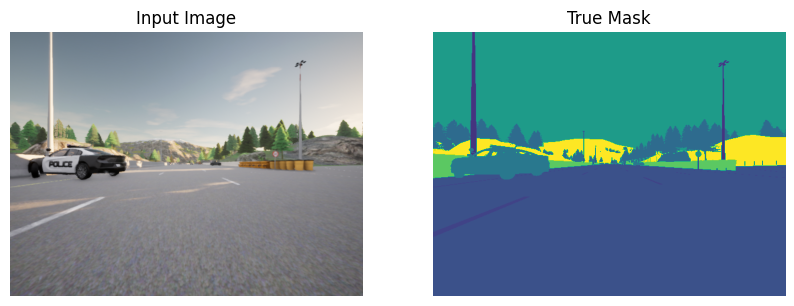

In [48]:

for image, mask in image_ds.take(1):
    sample_image, sample_mask = image, mask
    print(mask.shape)
display([sample_image, sample_mask])

# Training the model

In [70]:
EPOCHS = 40
VAL_SUBSPLITS = 5
BUFFER_SIZE = 500
BATCH_SIZE = 32

train_dataset = processed_image_ds.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
print(processed_image_ds.element_spec)
model_history = unet.fit(train_dataset, epochs=EPOCHS)

(TensorSpec(shape=(96, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(96, 128, 1), dtype=tf.uint8, name=None))
Epoch 1/40
34/34 [==============================] - 8s 156ms/step - loss: 0.1125 - accuracy: 0.9666
Epoch 2/40
34/34 [==============================] - 5s 155ms/step - loss: 0.1068 - accuracy: 0.9681
Epoch 3/40
34/34 [==============================] - 5s 156ms/step - loss: 0.1102 - accuracy: 0.9670
Epoch 4/40
34/34 [==============================] - 5s 158ms/step - loss: 0.1135 - accuracy: 0.9658
Epoch 5/40
34/34 [==============================] - 5s 158ms/step - loss: 0.1001 - accuracy: 0.9700
Epoch 6/40
34/34 [==============================] - 5s 158ms/step - loss: 0.0968 - accuracy: 0.9708
Epoch 7/40
34/34 [==============================] - 5s 159ms/step - loss: 0.0950 - accuracy: 0.9711
Epoch 8/40
34/34 [==============================] - 5s 160ms/step - loss: 0.0937 - accuracy: 0.9715
Epoch 9/40
34/34 [==============================] - 5s 162ms/step - loss: 0.093

In [71]:
# NOTE: here, we need to add another axis because imshow seems to only work with that extra dimension (specifying how many "channels")
def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    print(f"pred_mask.shape after argmax = {pred_mask.shape}")
    pred_mask = pred_mask[..., tf.newaxis]
    print(f"pred_mask.shape after tf.newaxis = {pred_mask.shape}")
    print(f"pred_mask[0].shape = {pred_mask[0].shape}")
    return pred_mask[0]

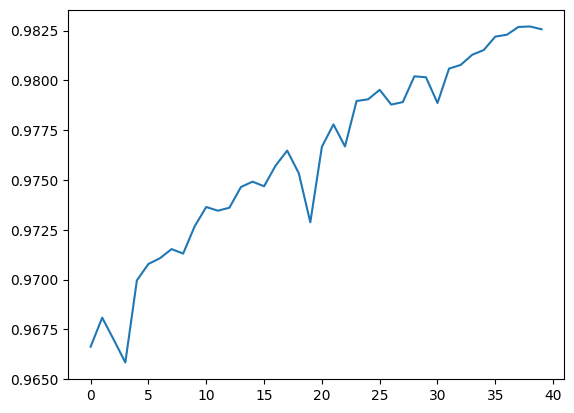

In [72]:
# Plot model accuracy
plt.plot(model_history.history["accuracy"])

# Showing the results (from training images)

In [73]:
def show_predictions(dataset=None, num=1):
    """
    Displays the first image of each of the num batches
    """
    if dataset:
        for image, mask in dataset.take(num):
            print(f"image.shape = {image.shape}")
            print(f"mask.shape = {mask.shape}")
            pred_mask = unet.predict(image)
            print(f"pred_mask.shape = {pred_mask.shape}")
            display([image[0], mask[0], create_mask(pred_mask)])
    else:
        display([sample_image, sample_mask, create_mask(unet.predict(sample_image[tf.newaxis, ...]))])

image.shape = (32, 96, 128, 3)
mask.shape = (32, 96, 128, 1)
1/1 [==============================] - 0s 22ms/step
pred_mask.shape = (32, 96, 128, 23)
pred_mask.shape after argmax = (32, 96, 128)
pred_mask.shape after tf.newaxis = (32, 96, 128, 1)
pred_mask[0].shape = (96, 128, 1)


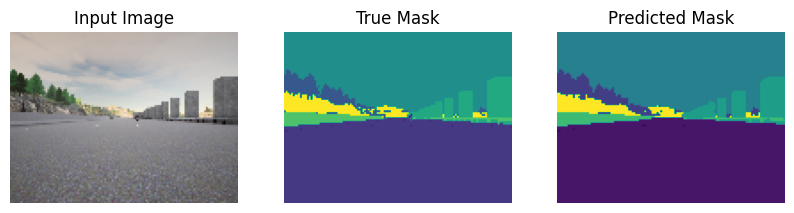

image.shape = (32, 96, 128, 3)
mask.shape = (32, 96, 128, 1)
1/1 [==============================] - 0s 24ms/step
pred_mask.shape = (32, 96, 128, 23)
pred_mask.shape after argmax = (32, 96, 128)
pred_mask.shape after tf.newaxis = (32, 96, 128, 1)
pred_mask[0].shape = (96, 128, 1)


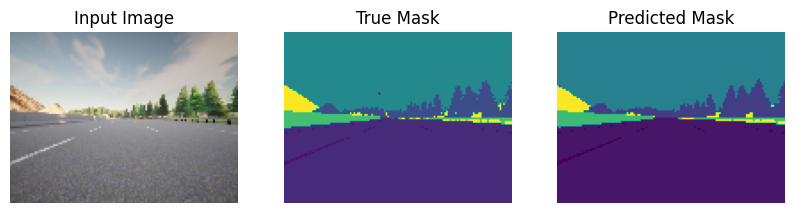

image.shape = (32, 96, 128, 3)
mask.shape = (32, 96, 128, 1)
1/1 [==============================] - 0s 23ms/step
pred_mask.shape = (32, 96, 128, 23)
pred_mask.shape after argmax = (32, 96, 128)
pred_mask.shape after tf.newaxis = (32, 96, 128, 1)
pred_mask[0].shape = (96, 128, 1)


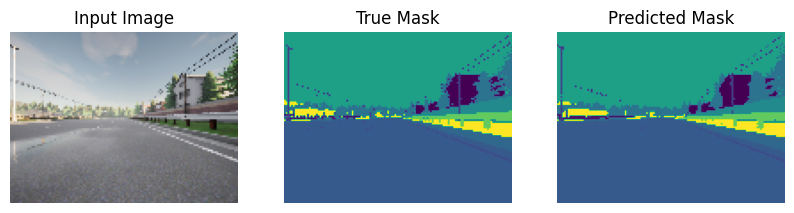

image.shape = (32, 96, 128, 3)
mask.shape = (32, 96, 128, 1)
1/1 [==============================] - 0s 32ms/step
pred_mask.shape = (32, 96, 128, 23)
pred_mask.shape after argmax = (32, 96, 128)
pred_mask.shape after tf.newaxis = (32, 96, 128, 1)
pred_mask[0].shape = (96, 128, 1)


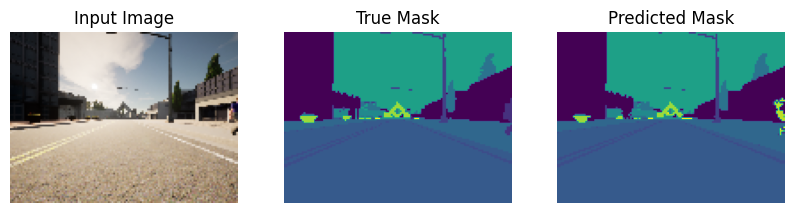

image.shape = (32, 96, 128, 3)
mask.shape = (32, 96, 128, 1)
1/1 [==============================] - 0s 21ms/step
pred_mask.shape = (32, 96, 128, 23)
pred_mask.shape after argmax = (32, 96, 128)
pred_mask.shape after tf.newaxis = (32, 96, 128, 1)
pred_mask[0].shape = (96, 128, 1)


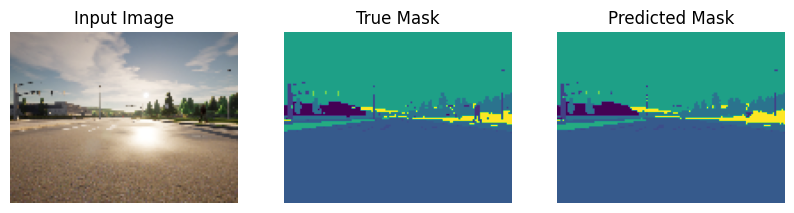

image.shape = (32, 96, 128, 3)
mask.shape = (32, 96, 128, 1)
1/1 [==============================] - 0s 23ms/step
pred_mask.shape = (32, 96, 128, 23)
pred_mask.shape after argmax = (32, 96, 128)
pred_mask.shape after tf.newaxis = (32, 96, 128, 1)
pred_mask[0].shape = (96, 128, 1)


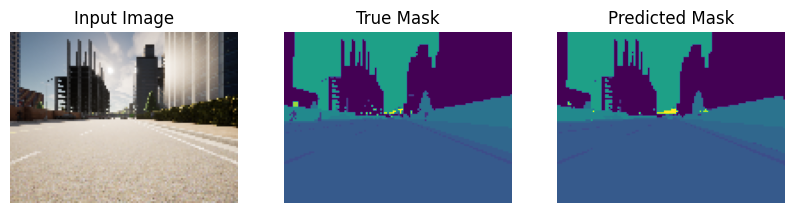

In [74]:
show_predictions(train_dataset, 6)